## Emergency Detection

In [4]:
import pandas as pd
from patient_emergency_detection import emergency_detection_workflow, prepare_data_for_detection, detect_emergency
from base.minio_utils import load_model_from_minio
from base.influx_utils import fetch_all_sensor_data
from base.homecare_hub_utils import send_info, send_todo

In [5]:
sensor_data = fetch_all_sensor_data(
    start_hours=24,
    interval_hours=24
)
prepared_df = prepare_data_for_detection(sensor_data)
prepared_df.tail(5)

2025-01-05 17:07:03 [INFO] patient_emergency_detection - Starting data preparation for detection.
2025-01-05 17:07:03 [INFO] patient_emergency_detection - Original data shape: (818, 5)
2025-01-05 17:07:03 [INFO] patient_emergency_detection - Handled 'sensor' as a list.
2025-01-05 17:07:03 [INFO] patient_emergency_detection - Timestamps converted to datetime.
2025-01-05 17:07:03 [INFO] patient_emergency_detection - Data sorted by timestamp.
2025-01-05 17:07:03 [INFO] patient_emergency_detection - Sensor names encoded successfully.
2025-01-05 17:07:03 [INFO] patient_emergency_detection - Mapped sensors to rooms.
2025-01-05 17:07:03 [INFO] patient_emergency_detection - Identified room-change points and assigned group IDs.
2025-01-05 17:07:03 [INFO] patient_emergency_detection - Calculated start and end times for each group.
2025-01-05 17:07:03 [INFO] patient_emergency_detection - Computed durations for each group.
2025-01-05 17:07:03 [INFO] patient_emergency_detection - Excluded 15 door-o

,group_id,room,start_time,end_time,duration,duration_seconds
143,157,livingroom,2025-01-05 15:12:57.755,2025-01-05 15:34:27.532,0 days 00:21:29.777000,1289.777
144,158,kitchen,2025-01-05 15:38:09.659,2025-01-05 15:41:37.965,0 days 00:03:28.306000,208.306
145,159,bathroom,2025-01-05 15:43:13.374,2025-01-05 15:43:52.287,0 days 00:00:38.913000,38.913
146,160,livingroom,2025-01-05 15:46:41.443,2025-01-05 15:48:28.301,0 days 00:01:46.858000,106.858
147,162,livingroom,2025-01-05 15:48:35.702,2025-01-05 15:49:11.244,0 days 00:00:35.542000,35.542


In [6]:
room_stats = load_model_from_minio("occupancy")
room_stats

2025-01-05 17:07:03 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-05 17:07:03 [INFO] base.minio_utils - [OCCUPANCY MODEL] Loading model 'model_occupancy_20250105095236.json' (version 1).
2025-01-05 17:07:03 [INFO] base.minio_utils - [OCCUPANCY MODEL] 'model_occupancy_20250105095236.json' downloaded.
2025-01-05 17:07:03 [INFO] base.minio_utils - [OCCUPANCY MODEL] Model deserialized successfully.


,room,mean,std
0,bathroom,204.033059,802.131316
1,kitchen,569.490492,1831.314490
2,livingroom,685.179492,3353.892677


In [7]:
_, message = emergency_detection_workflow()
print(message)

2025-01-05 17:07:03 [INFO] patient_emergency_detection - Initiating emergency detection workflow.
2025-01-05 17:07:05 [INFO] patient_emergency_detection - Fetched 818 sensor data records.
2025-01-05 17:07:05 [INFO] patient_emergency_detection - Retrieving patient location and duration.
2025-01-05 17:07:05 [INFO] patient_emergency_detection - Starting data preparation for detection.
2025-01-05 17:07:05 [INFO] patient_emergency_detection - Original data shape: (818, 5)
2025-01-05 17:07:05 [INFO] patient_emergency_detection - Handled 'sensor' as a list.
2025-01-05 17:07:05 [INFO] patient_emergency_detection - Timestamps converted to datetime.
2025-01-05 17:07:05 [INFO] patient_emergency_detection - Data sorted by timestamp.
2025-01-05 17:07:05 [INFO] patient_emergency_detection - Sensor names encoded successfully.
2025-01-05 17:07:05 [INFO] patient_emergency_detection - Mapped sensors to rooms.
2025-01-05 17:07:05 [INFO] patient_emergency_detection - Identified room-change points and assi

✅ All is well! ✅
 Patient is currently in livingroom for 0:00:36.
 No emergency detected.
 Expected duration (mean): 0:11:25,
 Standard deviation (std): 0:55:54,
 Allowed duration range: 0:00:00 - 2:59:07.


In [8]:
room = "livingroom"
duration = 240  # seconds
stats = pd.Series({"mean": 120, "std": 30})

_, result = detect_emergency(room, duration, stats)
print(result)

2025-01-05 17:07:05 [INFO] patient_emergency_detection - Room 'livingroom' stats - Mean: 120.00 seconds, Std: 30.00 seconds.
2025-01-05 17:07:05 [INFO] patient_emergency_detection - Duration bounds for emergency detection: (30.00, 210.00) seconds.
2025-01-05 17:07:05 [WARNING] patient_emergency_detection - 🚨 Emergency Alert! 🚨
 Room: livingroom,
 Patient has spent 0:04:00 here.
 Expected duration (mean): 0:02:00,
 Standard deviation (std): 0:00:30,
 Threshold used: 3,
 Allowed duration range: 0:00:30 - 0:03:30,
Duration is outside the allowed range!


🚨 Emergency Alert! 🚨
 Room: livingroom,
 Patient has spent 0:04:00 here.
 Expected duration (mean): 0:02:00,
 Standard deviation (std): 0:00:30,
 Threshold used: 3,
 Allowed duration range: 0:00:30 - 0:03:30,
Duration is outside the allowed range!


In [9]:
send_todo("🚨 Patient Emergency! 🚨", result, 2)

ToDo item saved successfully.
Response: None


## Motion Analysis

In [10]:
from motion_analysis import (
    visualize_transitions_heatmap, 
    plot_bidirectional_transaction_graph, 
    summary_of_sleep_time_and_time_outside,
    count_daily_visits,
    detect_wake_up_times,
    detect_went_to_sleep_times,
    create_separate_heat_maps)
from base.minio_utils import load_model_from_minio
import pandas as pd
from base.homecare_hub_utils import send_info
from motion_analysis import analyse_motion_patterns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [11]:
old_model = load_model_from_minio("motion", 2)
new_model = load_model_from_minio("motion", 1)

2025-01-05 17:07:05 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-05 17:07:05 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250103133818.json' (version 2).
2025-01-05 17:07:05 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250103133818.json' downloaded.
2025-01-05 17:07:05 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.
2025-01-05 17:07:05 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-05 17:07:05 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250103133819.json' (version 1).
2025-01-05 17:07:05 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250103133819.json' downloaded.
2025-01-05 17:07:05 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.


In [12]:
old_model.head()

,from,to,leave_time,enter_time
0,livingroomdoor,kitchen,2024-11-29 15:51:17.000,2024-11-29 16:03:53.625
1,kitchen,livingroomdoor,2024-11-29 16:06:44.833,2024-11-29 16:06:54.000
2,livingroomdoor,kitchen,2024-11-29 16:06:54.000,2024-11-29 16:07:01.214
3,kitchen,livingroomdoor,2024-11-29 16:11:49.475,2024-11-29 16:11:52.000
4,livingroomdoor,kitchen,2024-11-29 16:11:52.000,2024-11-29 16:11:56.395


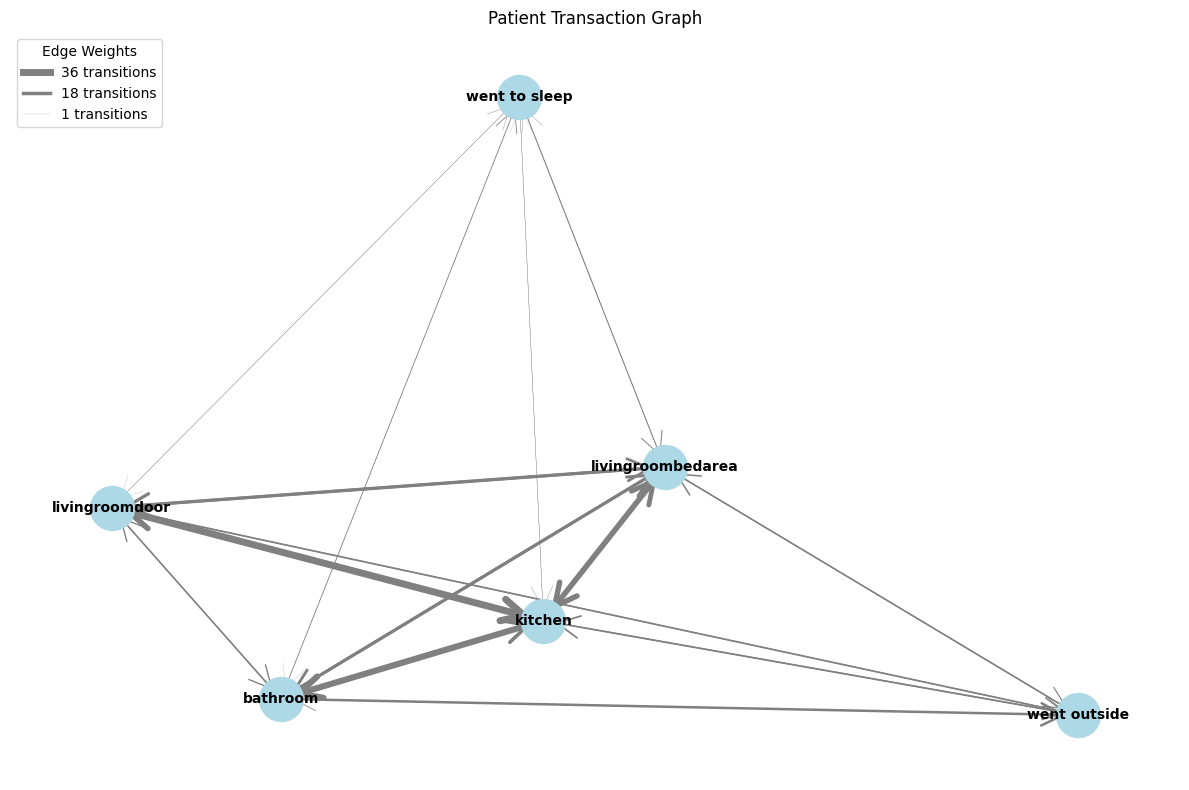

In [13]:
plot_bidirectional_transaction_graph(old_model)

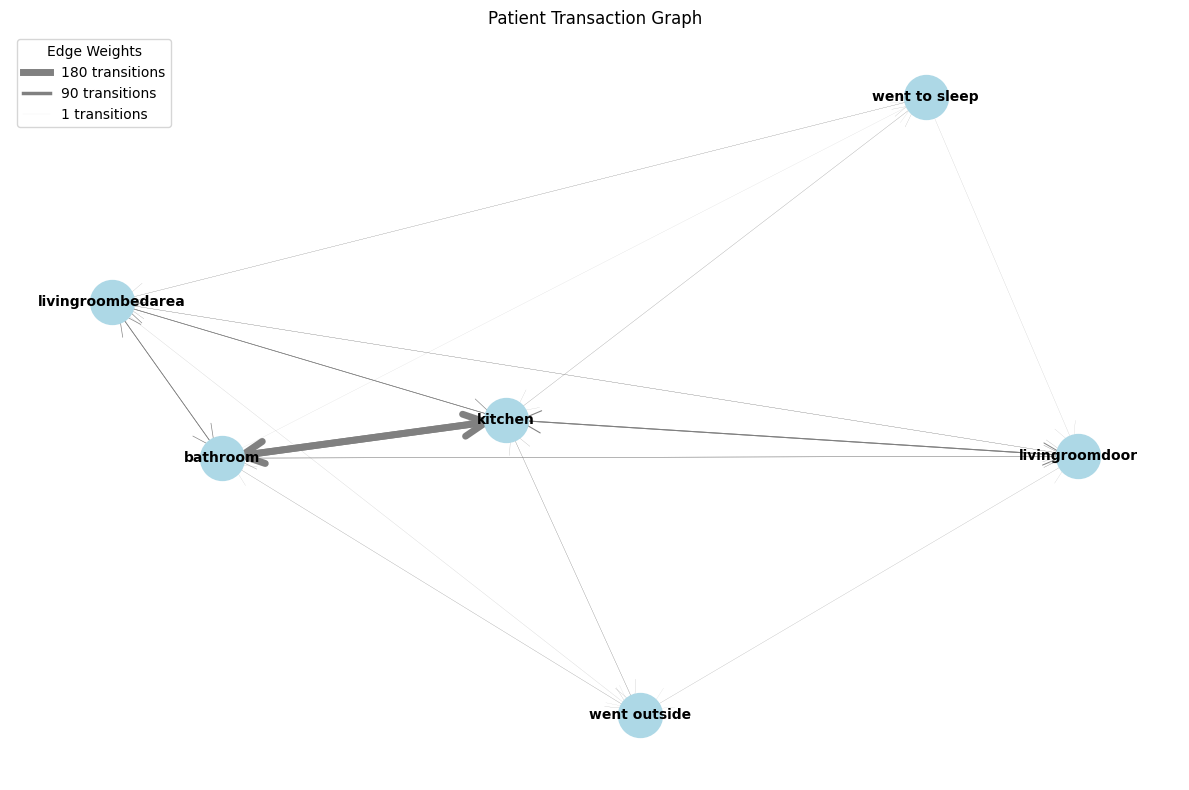

In [14]:
plot_bidirectional_transaction_graph(new_model)

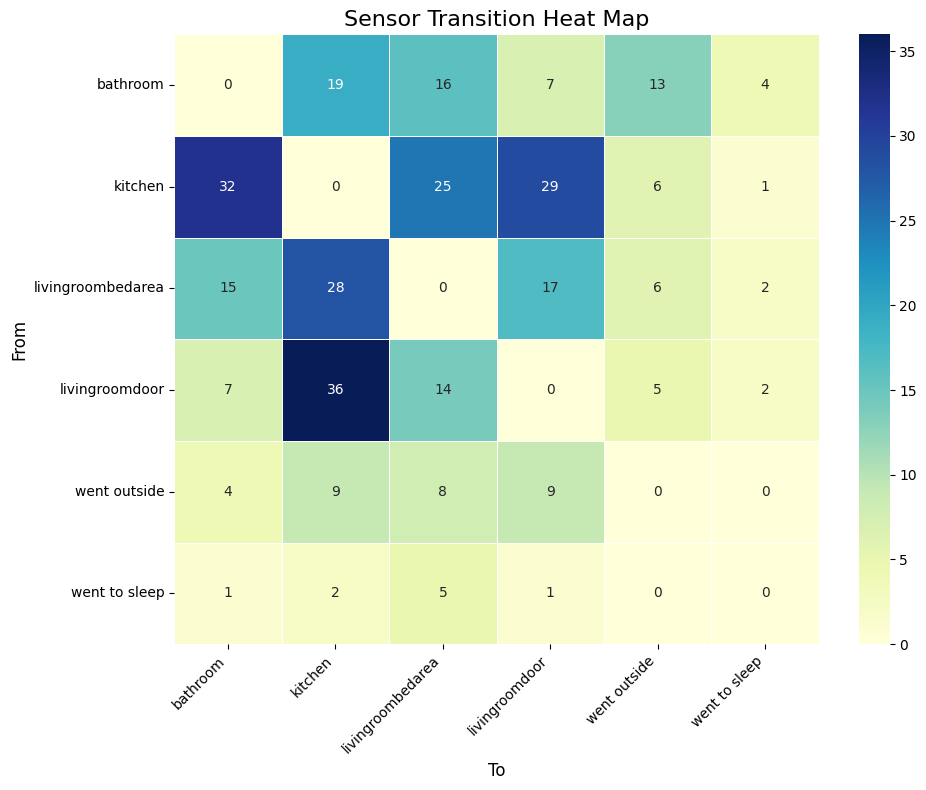

In [15]:
visualize_transitions_heatmap(old_model)

#### Counting the sleep and went outside periods

In [16]:
summary_of_sleep_time_and_time_outside(old_model)

,date,day_of_week,sleep_time,time_outside
0,2024-11-29,Friday,0,6h 16m
1,2024-11-30,Saturday,0,5h 20m
2,2024-12-01,Sunday,1h 45m,2h 28m
3,2024-12-02,Monday,8h 28m,12h 44m
4,2024-12-03,Tuesday,7h 11m,8h 57m
5,2024-12-04,Wednesday,6h 54m,4h 50m
6,2024-12-05,Thursday,4h 9m,11h 27m
7,2024-12-06,Friday,1h 37m,1h 38m


In [17]:
summary_of_sleep_time_and_time_outside(new_model)

,date,day_of_week,sleep_time,time_outside
0,2024-11-22,Friday,0h 32m,1h 35m
1,2024-11-23,Saturday,0h 46m,3h 48m
2,2024-11-24,Sunday,1h 49m,8h 19m
3,2024-11-25,Monday,6h 32m,2h 55m
4,2024-11-26,Tuesday,1h 47m,4h 56m
5,2024-11-27,Wednesday,4h 37m,1h 7m
6,2024-11-28,Thursday,6h 33m,2h 30m


#### Detect daliy trips to places

In [18]:
count_daily_visits(new_model, transition_state='bathroom')

,trip_date,bathroom_trip_count
0,2024-11-22,10
1,2024-11-23,44
2,2024-11-24,71
3,2024-11-25,20
4,2024-11-26,49
5,2024-11-27,13
6,2024-11-28,2


In [19]:
count_daily_visits(new_model, transition_state='kitchen')

,trip_date,kitchen_trip_count
0,2024-11-22,12
1,2024-11-23,41
2,2024-11-24,76
3,2024-11-25,23
4,2024-11-26,55
5,2024-11-27,13
6,2024-11-28,9


In [20]:
count_daily_visits(new_model, transition_state='livingroombedarea')

,trip_date,livingroombedarea_trip_count
0,2024-11-22,2
1,2024-11-23,21
2,2024-11-24,6
3,2024-11-25,1
4,2024-11-26,6
5,2024-11-27,7
6,2024-11-28,1


In [21]:
count_daily_visits(old_model, transition_state='livingroomdoor')

,trip_date,livingroomdoor_trip_count
0,2024-11-29,9
1,2024-11-30,13
2,2024-12-01,12
3,2024-12-02,2
4,2024-12-03,11
5,2024-12-04,10
6,2024-12-05,4
7,2024-12-06,2


#### Wake up times

In [22]:
detect_wake_up_times(new_model)

,wake_up_time
26,2024-11-22 22:35:23.179
141,2024-11-24 00:14:56.818
310,2024-11-25 05:26:02.000
336,2024-11-25 17:29:48.000
361,2024-11-26 01:47:15.327
484,2024-11-27 01:54:12.349
486,2024-11-27 02:29:05.001
494,2024-11-27 08:32:14.606
525,2024-11-28 05:42:15.000
532,2024-11-28 07:18:04.909


In [23]:
detect_went_to_sleep_times(old_model)

,went_to_sleep
110,2024-12-01 22:12:10.000
112,2024-12-01 23:08:19.118
114,2024-12-02 04:23:16.000
123,2024-12-02 23:28:33.267
179,2024-12-04 00:14:02.441
183,2024-12-04 06:14:26.732
227,2024-12-05 01:14:20.083
229,2024-12-05 05:31:38.079
288,2024-12-06 01:01:32.820


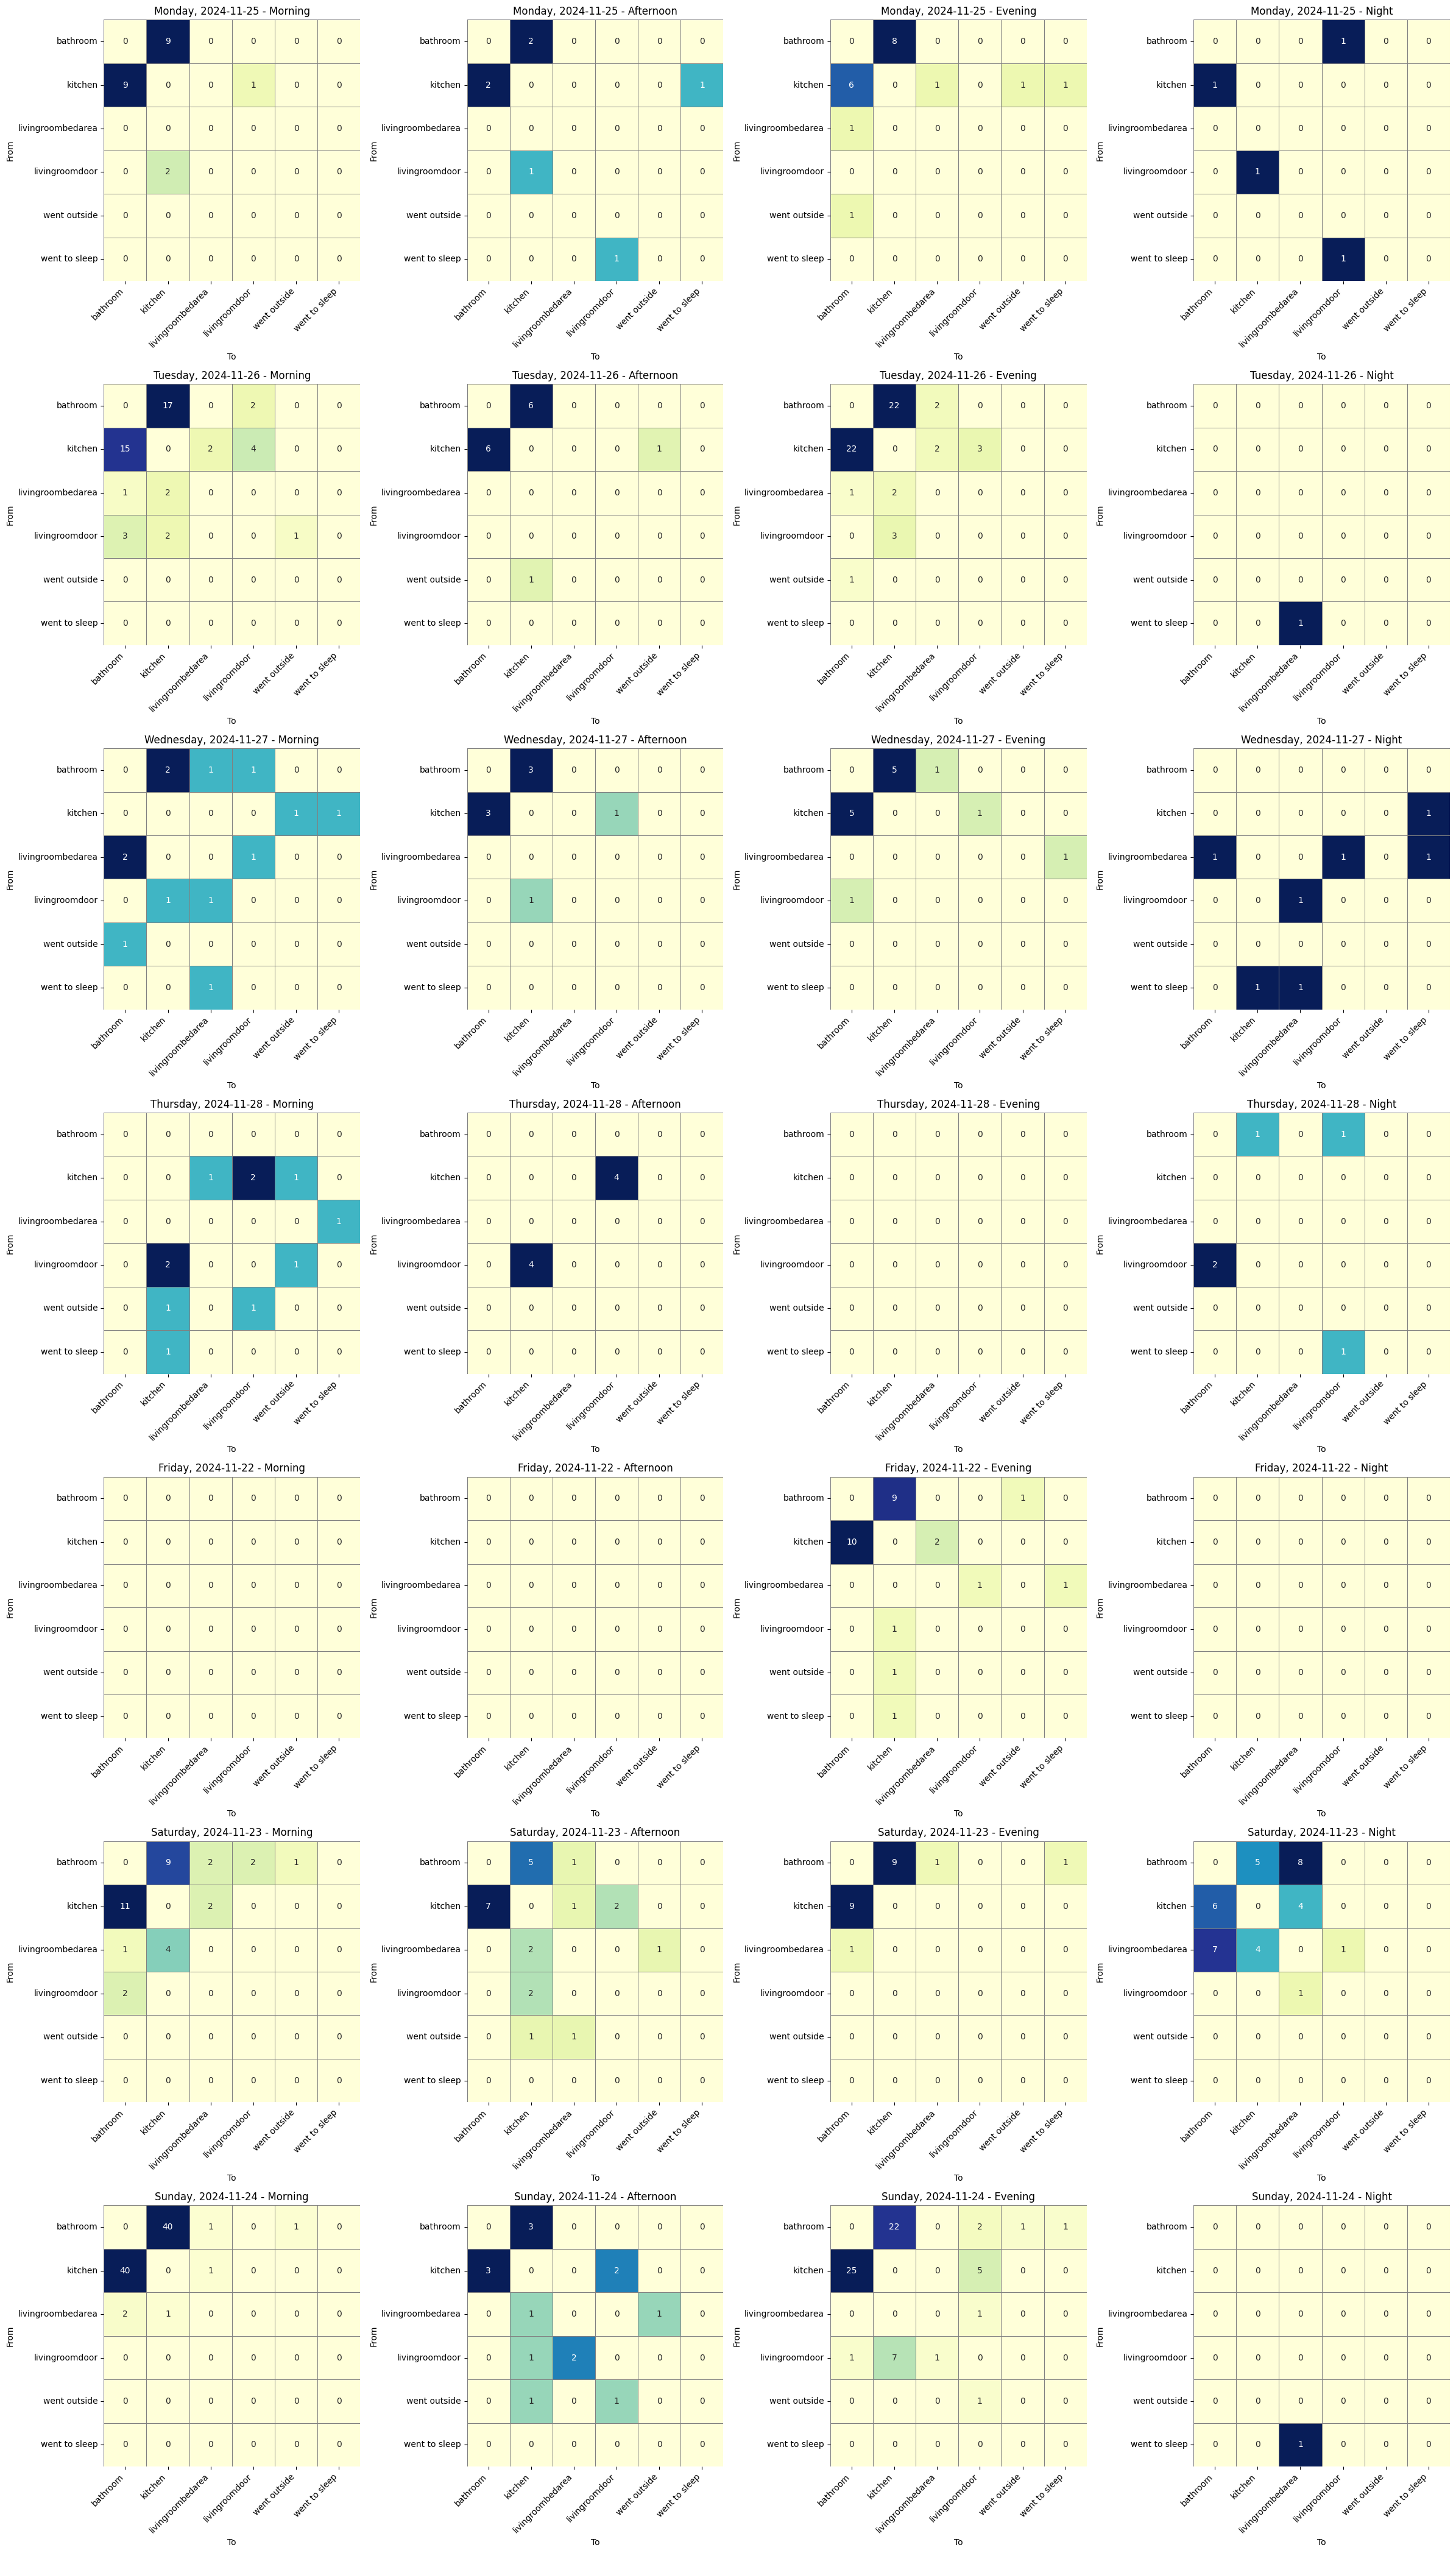

In [24]:
create_separate_heat_maps(new_model)

In [25]:
message = analyse_motion_patterns()

2025-01-05 17:07:20 [INFO] motion_analysis - 🔄 Loading old and new motion models from MinIO...
2025-01-05 17:07:20 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-05 17:07:21 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250103133818.json' (version 2).
2025-01-05 17:07:21 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250103133818.json' downloaded.
2025-01-05 17:07:21 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.
2025-01-05 17:07:21 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-05 17:07:21 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250103133819.json' (version 1).
2025-01-05 17:07:21 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250103133819.json' downloaded.
2025-01-05 17:07:21 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.
2025-01-05 17:07:21 [INFO] motion_analysis - ✅ Models loaded successfully.

2025-01-0

In [26]:
print(message)

📊 **📈 Motion Patterns Analysis Report 📉📊**

📅 **Report Date:** 2025-01-05 16:07:21 UTC

### 🕰️ **Old Motion Model** 🕰️

#### 🛌 Sleep Time and 🌳 Time Outside Summary

```      date day_of_week sleep_time time_outside
2024-11-29      Friday          0       6h 16m
2024-11-30    Saturday          0       5h 20m
2024-12-01      Sunday     1h 45m       2h 28m
2024-12-02      Monday     8h 28m      12h 44m
2024-12-03     Tuesday     7h 11m       8h 57m
2024-12-04   Wednesday     6h 54m       4h 50m
2024-12-05    Thursday      4h 9m      11h 27m
2024-12-06      Friday     1h 37m       1h 38m```

#### 🚽 **Daily Visits to Bathroom**

``` trip_date  bathroom_trip_count
2024-12-02                    2
2024-12-03                   18
2024-12-04                   10
2024-12-05                   14
2024-12-06                   15```

#### 🚽 **Daily Visits to Kitchen**

``` trip_date  kitchen_trip_count
2024-11-29                  11
2024-11-30                  23
2024-12-01                  13
2024-

In [27]:
from motion_analysis import analyse_motion_patterns
analyse_motion_patterns()

2025-01-05 17:07:21 [INFO] motion_analysis - 🔄 Loading old and new motion models from MinIO...
2025-01-05 17:07:21 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-05 17:07:21 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250103133818.json' (version 2).
2025-01-05 17:07:21 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250103133818.json' downloaded.
2025-01-05 17:07:21 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.
2025-01-05 17:07:21 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-05 17:07:22 [INFO] base.minio_utils - [MOTION MODEL] Loading model 'model_motion_20250103133819.json' (version 1).
2025-01-05 17:07:22 [INFO] base.minio_utils - [MOTION MODEL] 'model_motion_20250103133819.json' downloaded.
2025-01-05 17:07:22 [INFO] base.minio_utils - [MOTION MODEL] Model deserialized successfully.
2025-01-05 17:07:22 [INFO] motion_analysis - ✅ Models loaded successfully.

2025-01-0

'📊 **📈 Motion Patterns Analysis Report 📉📊**\n\n📅 **Report Date:** 2025-01-05 16:07:22 UTC\n\n### 🕰️ **Old Motion Model** 🕰️\n\n#### 🛌 Sleep Time and 🌳 Time Outside Summary\n\n```      date day_of_week sleep_time time_outside\n2024-11-29      Friday          0       6h 16m\n2024-11-30    Saturday          0       5h 20m\n2024-12-01      Sunday     1h 45m       2h 28m\n2024-12-02      Monday     8h 28m      12h 44m\n2024-12-03     Tuesday     7h 11m       8h 57m\n2024-12-04   Wednesday     6h 54m       4h 50m\n2024-12-05    Thursday      4h 9m      11h 27m\n2024-12-06      Friday     1h 37m       1h 38m```\n\n#### 🚽 **Daily Visits to Bathroom**\n\n``` trip_date  bathroom_trip_count\n2024-12-02                    2\n2024-12-03                   18\n2024-12-04                   10\n2024-12-05                   14\n2024-12-06                   15```\n\n#### 🚽 **Daily Visits to Kitchen**\n\n``` trip_date  kitchen_trip_count\n2024-11-29                  11\n2024-11-30                  23\n202

## Burglary Detection

In [28]:
from burglary_detection import BurglaryDetector
from burglary_detection import create_burglary_message, detect_burglary
from motion_model import train_motion_model
from base.homecare_hub_utils import send_todo

In [29]:
detector = BurglaryDetector(contamination=0.01, model_type='burglary')
detector.load_model(version=1)

2025-01-05 17:07:22 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-05 17:07:22 [INFO] base.minio_utils - [BURGLARY MODEL] Loading model 'model_burglary_20250103170304.json' (version 1).
2025-01-05 17:07:24 [INFO] base.minio_utils - [BURGLARY MODEL] 'model_burglary_20250103170304.json' downloaded.
2025-01-05 17:07:24 [INFO] base.minio_utils - [BURGLARY MODEL] Model deserialized successfully.


Model version 1 loaded from MinIO successfully.


In [30]:
motion_model = train_motion_model(start_hours=24*7, interval_hours=24*7, time_threshold_seconds=1800)
detection = detector.detect(motion_model)

2025-01-05 17:07:24 [INFO] motion_model - Fetching sensor data starting 168 hours ago for a duration of 168 hours.
2025-01-05 17:07:24 [INFO] motion_model - Preparing data for occupancy model.
2025-01-05 17:07:24 [INFO] occupancy_model - Original data shape: (3880, 5)
2025-01-05 17:07:24 [INFO] motion_model - Preprocessing data for motion analysis.
2025-01-05 17:07:24 [INFO] motion_model - Creating transition DataFrame with a time threshold of 1800 seconds.
2025-01-05 17:07:24 [INFO] motion_model - Motion model trained.
2025-01-05 17:07:24 [INFO] burglary_detection - Anomaly detected: Yes


In [31]:
detection

(                  from                 to              leave_time  \
 0             bathroom  livingroombedarea 2025-01-01 20:40:00.413   
 1    livingroombedarea       went outside 2025-01-01 22:04:35.178   
 2         went outside           bathroom 2025-01-01 23:27:11.502   
 3             bathroom      went to sleep 2025-01-02 00:42:30.393   
 4        went to sleep            kitchen 2025-01-02 01:21:35.170   
 5              kitchen      went to sleep 2025-01-02 01:21:44.041   
 6        went to sleep           bathroom 2025-01-02 08:18:47.541   
 7             bathroom            kitchen 2025-01-02 10:37:01.666   
 8              kitchen  livingroombedarea 2025-01-02 10:52:08.733   
 9    livingroombedarea            kitchen 2025-01-02 10:52:31.072   
 10             kitchen  livingroombedarea 2025-01-02 10:52:31.872   
 11   livingroombedarea            kitchen 2025-01-02 10:52:43.327   
 12             kitchen  livingroombedarea 2025-01-02 10:52:44.006   
 13   livingroombeda

In [32]:
create_burglary_message(detection[0], detection[1])

2025-01-05 17:07:24 [INFO] burglary_detection - Burglary alert message created successfully.


'🚔 **Burglary Alert!** 🚔\nPotential burglary detected with the following details:\n\n🔹 **From:** livingroombedarea ➡️ **To:** kitchen\n🔸 **Leave Time:** 2025-01-02 17:09:06\n🔸 **Enter Time:** 2025-01-02 17:36:37\n\n🔹 **From:** livingroombedarea ➡️ **To:** kitchen\n🔸 **Leave Time:** 2025-01-04 00:30:09\n🔸 **Enter Time:** 2025-01-04 00:43:53\n\n🔹 **From:** livingroombedarea ➡️ **To:** bathroom\n🔸 **Leave Time:** 2025-01-04 09:23:46\n🔸 **Enter Time:** 2025-01-04 09:53:09\n\n🔹 **From:** livingroomdoor ➡️ **To:** kitchen\n🔸 **Leave Time:** 2025-01-04 21:56:46\n🔸 **Enter Time:** 2025-01-04 22:23:10\n\n⚠️ Please check the premises immediately. ⚠️'

In [33]:
is_burglary, msg = detect_burglary(24*7, 24*7, 1800)
if is_burglary:
    send_todo("🏠🚔 Burglary Alert! 🏠🔐", msg, 2)

2025-01-05 17:07:24 [INFO] base.minio_utils - Initialized MinIO client successfully.
2025-01-05 17:07:24 [INFO] base.minio_utils - [BURGLARY MODEL] Loading model 'model_burglary_20250103170304.json' (version 1).
2025-01-05 17:07:25 [INFO] base.minio_utils - [BURGLARY MODEL] 'model_burglary_20250103170304.json' downloaded.
2025-01-05 17:07:25 [INFO] base.minio_utils - [BURGLARY MODEL] Model deserialized successfully.
2025-01-05 17:07:25 [INFO] motion_model - Fetching sensor data starting 168 hours ago for a duration of 168 hours.


Model version 1 loaded from MinIO successfully.


2025-01-05 17:07:26 [INFO] motion_model - Preparing data for occupancy model.
2025-01-05 17:07:26 [INFO] occupancy_model - Original data shape: (3880, 5)
2025-01-05 17:07:26 [INFO] motion_model - Preprocessing data for motion analysis.
2025-01-05 17:07:26 [INFO] motion_model - Creating transition DataFrame with a time threshold of 1800 seconds.
2025-01-05 17:07:26 [INFO] motion_model - Motion model trained.
2025-01-05 17:07:26 [INFO] burglary_detection - Anomaly detected: Yes
2025-01-05 17:07:26 [INFO] burglary_detection - Burglary alert message created successfully.


ToDo item saved successfully.
Response: None
